# Notebook D: Generate recommendations for Cycle 2 using ART 

This notebook uses the designs created by ART and the corresponding isoprenol production levels generated through OMG, to build a predictive model through ART. ART's model will be able to predict isoprenol production given the design as input. We will then use this model to recommend designs that optimize isoprenol production.

Tested using **ART_v3.6** kernel on jprime.lbl.gov 

## Inputs and Outputs

#### Required files to run this notebook:
- None, data will be automatically drawn from EDD

#### Files generated by running this notebook:

- `ART_training_EDDstyle.csv`, a file for ART front end import 
- Standard ART output files (containing recommendations, predictive accuracy metrics, plots of predictions vs observations for the train data set, pickle file containing previously trained ART object) in the corresponding directory.
- `ARTrecommendations.csv`, a file containing the ART recommendations


## Setup

In [1]:
from edd_utils import login, export_study

## Downloading the data from EDD

Export the EDD study that contains isoprenol production data using `edd-utils` package (use your own username for EDD):

In [2]:
session = login(edd_server='public-edd.agilebiofoundry.org', user='hgmartin')


Password for hgmartin:  ················


In [3]:
edd_server = 'public-edd.agilebiofoundry.org'
df = export_study(session, 'multiomics-be-strains-data-089b', edd_server=edd_server)
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,10114,Multiomics BE strains data,10115,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,Metabolomics,10261,Strain 1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.00000,9.0
1,10114,Multiomics BE strains data,10116,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,Metabolomics,10247,Strain 2,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.55210,9.0
2,10114,Multiomics BE strains data,10117,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,Metabolomics,10277,Strain 3,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.34920,9.0
3,10114,Multiomics BE strains data,10118,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,Metabolomics,10281,Strain 4,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.55185,9.0
4,10114,Multiomics BE strains data,10119,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,Metabolomics,10292,Strain 5,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.08012,9.0


Keep only the necesary columns:

In [4]:
df = df[['Line Name','Line Description','Measurement Type', 'Value']]
df.head()

,Line Name,Line Description,Measurement Type,Value
0,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.00000
1,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.55210
2,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.34920
3,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.55185
4,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.08012


### Adding design information to the data frame

Add columns for each reaction:

In [5]:
reactions = df['Line Description'][0].split('_')[::2]
for rxn in reactions:
    df[rxn] = None

df.tail()

,Line Name,Line Description,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,ACCOAC_0.0_MDH_0.0_PTAr_2.0_CS_2.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
92,Strain 93,ACCOAC_1.0_MDH_2.0_PTAr_0.0_CS_0.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
93,Strain 94,ACCOAC_0.0_MDH_2.0_PTAr_0.0_CS_1.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
94,Strain 95,ACCOAC_0.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
95,WT,Wild type E. coli,3-METHYL-3-BUTEN-1-OL,0.46188,None,None,None,None,None,None,None,None


And assign values for each reaction and line:

In [6]:
for i in range(len(df)):
    if df['Line Name'][i]=='WT':
        for r in range(len(reactions)):
            df.iloc[i, (4+r)] = float(1)
    else:
        values = df.loc[i]['Line Description'].split('_')[1::2]
        for r,value in zip(range(len(reactions)),values):
            df.iloc[i, (4+r)] = float(value)

df = df.drop(columns='Line Description')


Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [7]:
df.tail()

,Line Name,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,3-METHYL-3-BUTEN-1-OL,0.00000,0,0,2,2,0,2,0,2
92,Strain 93,3-METHYL-3-BUTEN-1-OL,0.00000,1,2,0,0,0,2,2,0
93,Strain 94,3-METHYL-3-BUTEN-1-OL,0.00000,0,2,0,1,0,2,1,1
94,Strain 95,3-METHYL-3-BUTEN-1-OL,0.00000,0,1,2,0,1,1,0,2
95,WT,3-METHYL-3-BUTEN-1-OL,0.46188,1,1,1,1,1,1,1,1


Rename `Value` column to the formal metabolite name:

In [8]:
production_name = df['Measurement Type'][0]
df = df.rename(columns={'Value': production_name})
df = df.drop(columns='Measurement Type')
df.tail()


,Line Name,3-METHYL-3-BUTEN-1-OL,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,0.00000,0,0,2,2,0,2,0,2
92,Strain 93,0.00000,1,2,0,0,0,2,2,0
93,Strain 94,0.00000,0,2,0,1,0,2,1,1
94,Strain 95,0.00000,0,1,2,0,1,1,0,2
95,WT,0.46188,1,1,1,1,1,1,1,1


### Saving the data in EDD format, for use with the front end. 

Pivot the dataframe back to EDD format, now including all the reaction names and modifications:

In [9]:
df = df.set_index('Line Name').stack().reset_index()
df.columns = ['Line Name', 'Measurement Type', 'Value']
df.head()

,Line Name,Measurement Type,Value
0,Strain 1,3-METHYL-3-BUTEN-1-OL,0.0
1,Strain 1,ACCOAC,1.0
2,Strain 1,MDH,1.0
3,Strain 1,PTAr,2.0
4,Strain 1,CS,0.0


Save this dataframe to a file for ART front end:

In [10]:
data_file = '../data/ART_training_EDDstyle.csv'
df.to_csv(data_file, header=True, index=False)

Store the names of all variables:

In [11]:
variables = df['Measurement Type'][df['Line Name']=='Strain 1'].tolist()


# Running ART to create a predictive model of production and generate recommendations

The first step is to make sure the ART library is available in your kernel (ART_v3.6 has all the necessary dependencies). Clone the corresponding git repository:

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____
**WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

(Information about licensing ART is available at https://github.com/JBEI/ART.)

We can then add library to the path and do the necessary imports:

<!-- <font color='red'> _____**is the append needed if it is in the kernel?** </font> -->

In [12]:
import sys
sys.path.append('../../AutomatedRecommendationTool')
    
from edd_utils import login, export_study
from art.core import *
import pickle

And then define some ART input parameters:

In [13]:
user_params = {}
user_params['num_recommendations'] = 10                  # Number of final recommendations
user_params['output_directory'] = '../data/art_output/'  # Directory to store output files

## Training ART

The first step is to create a dictionary that contains the settings for ART:

In [14]:
art_params = {
    'response_var': [variables[0]],
    'input_var': variables[1:],
    'seed': 10,
    'num_recommendations': user_params['num_recommendations'],   
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_directory']
}

With this setting, you can now run ART. However, this takes around 25min, so you can set run_art to False and load the previously run model, which will be much faster:

In [15]:
run_art = True

In [16]:
%%time
if run_art:
    art = RecommendationEngine(df, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6595131800190912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462472422719335, but should be close to 0.8. Try to increase the number of tuning steps.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9298139747992613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 24min 28s, sys: 12min 41s, total: 37min 9s
Wall time: 21min 12s


By calling the `evaluate_models_cv` function you can take a look at the predictive accuracy metrics:

In [17]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.204693,inf,0.155104,0.065956,-0.730791
Random Forest Regressor,0.026081,NaN,0.050578,0.003238,0.915022
TPOT Regressor,0.005641,NaN,0.015564,0.000274,0.992808
Support Vector Regressor,0.106237,inf,0.074779,0.016878,0.557095
Kernel Ridge Regressor,0.092691,inf,0.078948,0.014824,0.610985
K-NN Regressor,0.118036,NaN,0.101839,0.024304,0.362238
Gaussian Process Regressor,0.086795,inf,0.076816,0.013434,0.647471
Gradient Boosting Regressor,0.052986,inf,0.052229,0.005535,0.854744
Ensemble Model,0.008256,inf,0.014691,0.000284,0.992548


We can also generate the predictions vs observed plots, to gauge the quality of the predictions:

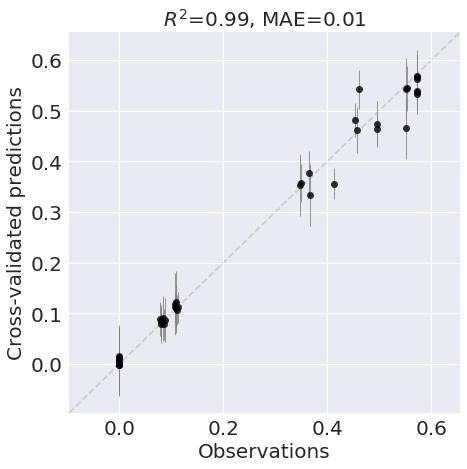

In [18]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=True)

In [19]:
utils.save_pkl_object(art)


## Recommending new designs

Once the model is trained, we can use it to find inputs that will optimize production. In this demo case the input phase space is quite small (three possible genetic modifications for 8 reactions), so we can enumerate all possible values for input variables:

In [20]:
categories = set(df['Value'][df['Measurement Type'].isin(art.input_var)])


### Generating all possible designs

We create the set of all possible designs:

In [21]:
n_modifications = len(categories)
num_of_reactions = art.num_input_var
num_of_designs = n_modifications**num_of_reactions
strains = np.zeros((num_of_designs, num_of_reactions))


In [22]:
i = 0

for d1 in range(3):
    for d2 in range(3):
        for d3 in range(3):
            for d4 in range(3):
                for d5 in range(3):
                    for d6 in range(3):
                        for d7 in range(3):
                            for d8 in range(3):
                                strains[i,:] = np.hstack((d1,d2,d3,d4,d5,d6,d7,d8)).astype(int)
                                i+=1

And then calculate the mean predicted production and standard deviation for all possible designs:

In [23]:
pp_mean, pp_std = art.post_pred_stats(strains)


The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [24]:
art.rel_eng_accuracy = 0.01

### Using ART for generating recommendations

Now we use ART to recommend the designs that will optimize production. The objective function is defined as the mean predicted production:  

<!-- <font color='red'> _____**This is not very clear..** </font>  -->

In [25]:
obj_func = pp_mean 
data = np.hstack((strains, obj_func, obj_func))

art.recommend(data=data)
art.recommendations


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,3-METHYL-3-BUTEN-1-OL
0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584
1,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193
2,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167
3,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039
4,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967
5,2.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.571282
6,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,0.570968
7,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.570915
8,1.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570771
9,2.0,1.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570769


It turns out that all recommendations indicate that the CS and ACACT1r reaction fluxes should double and PPCK should be knocked out. 

We can visualize the predicted distribution for all recommendations:

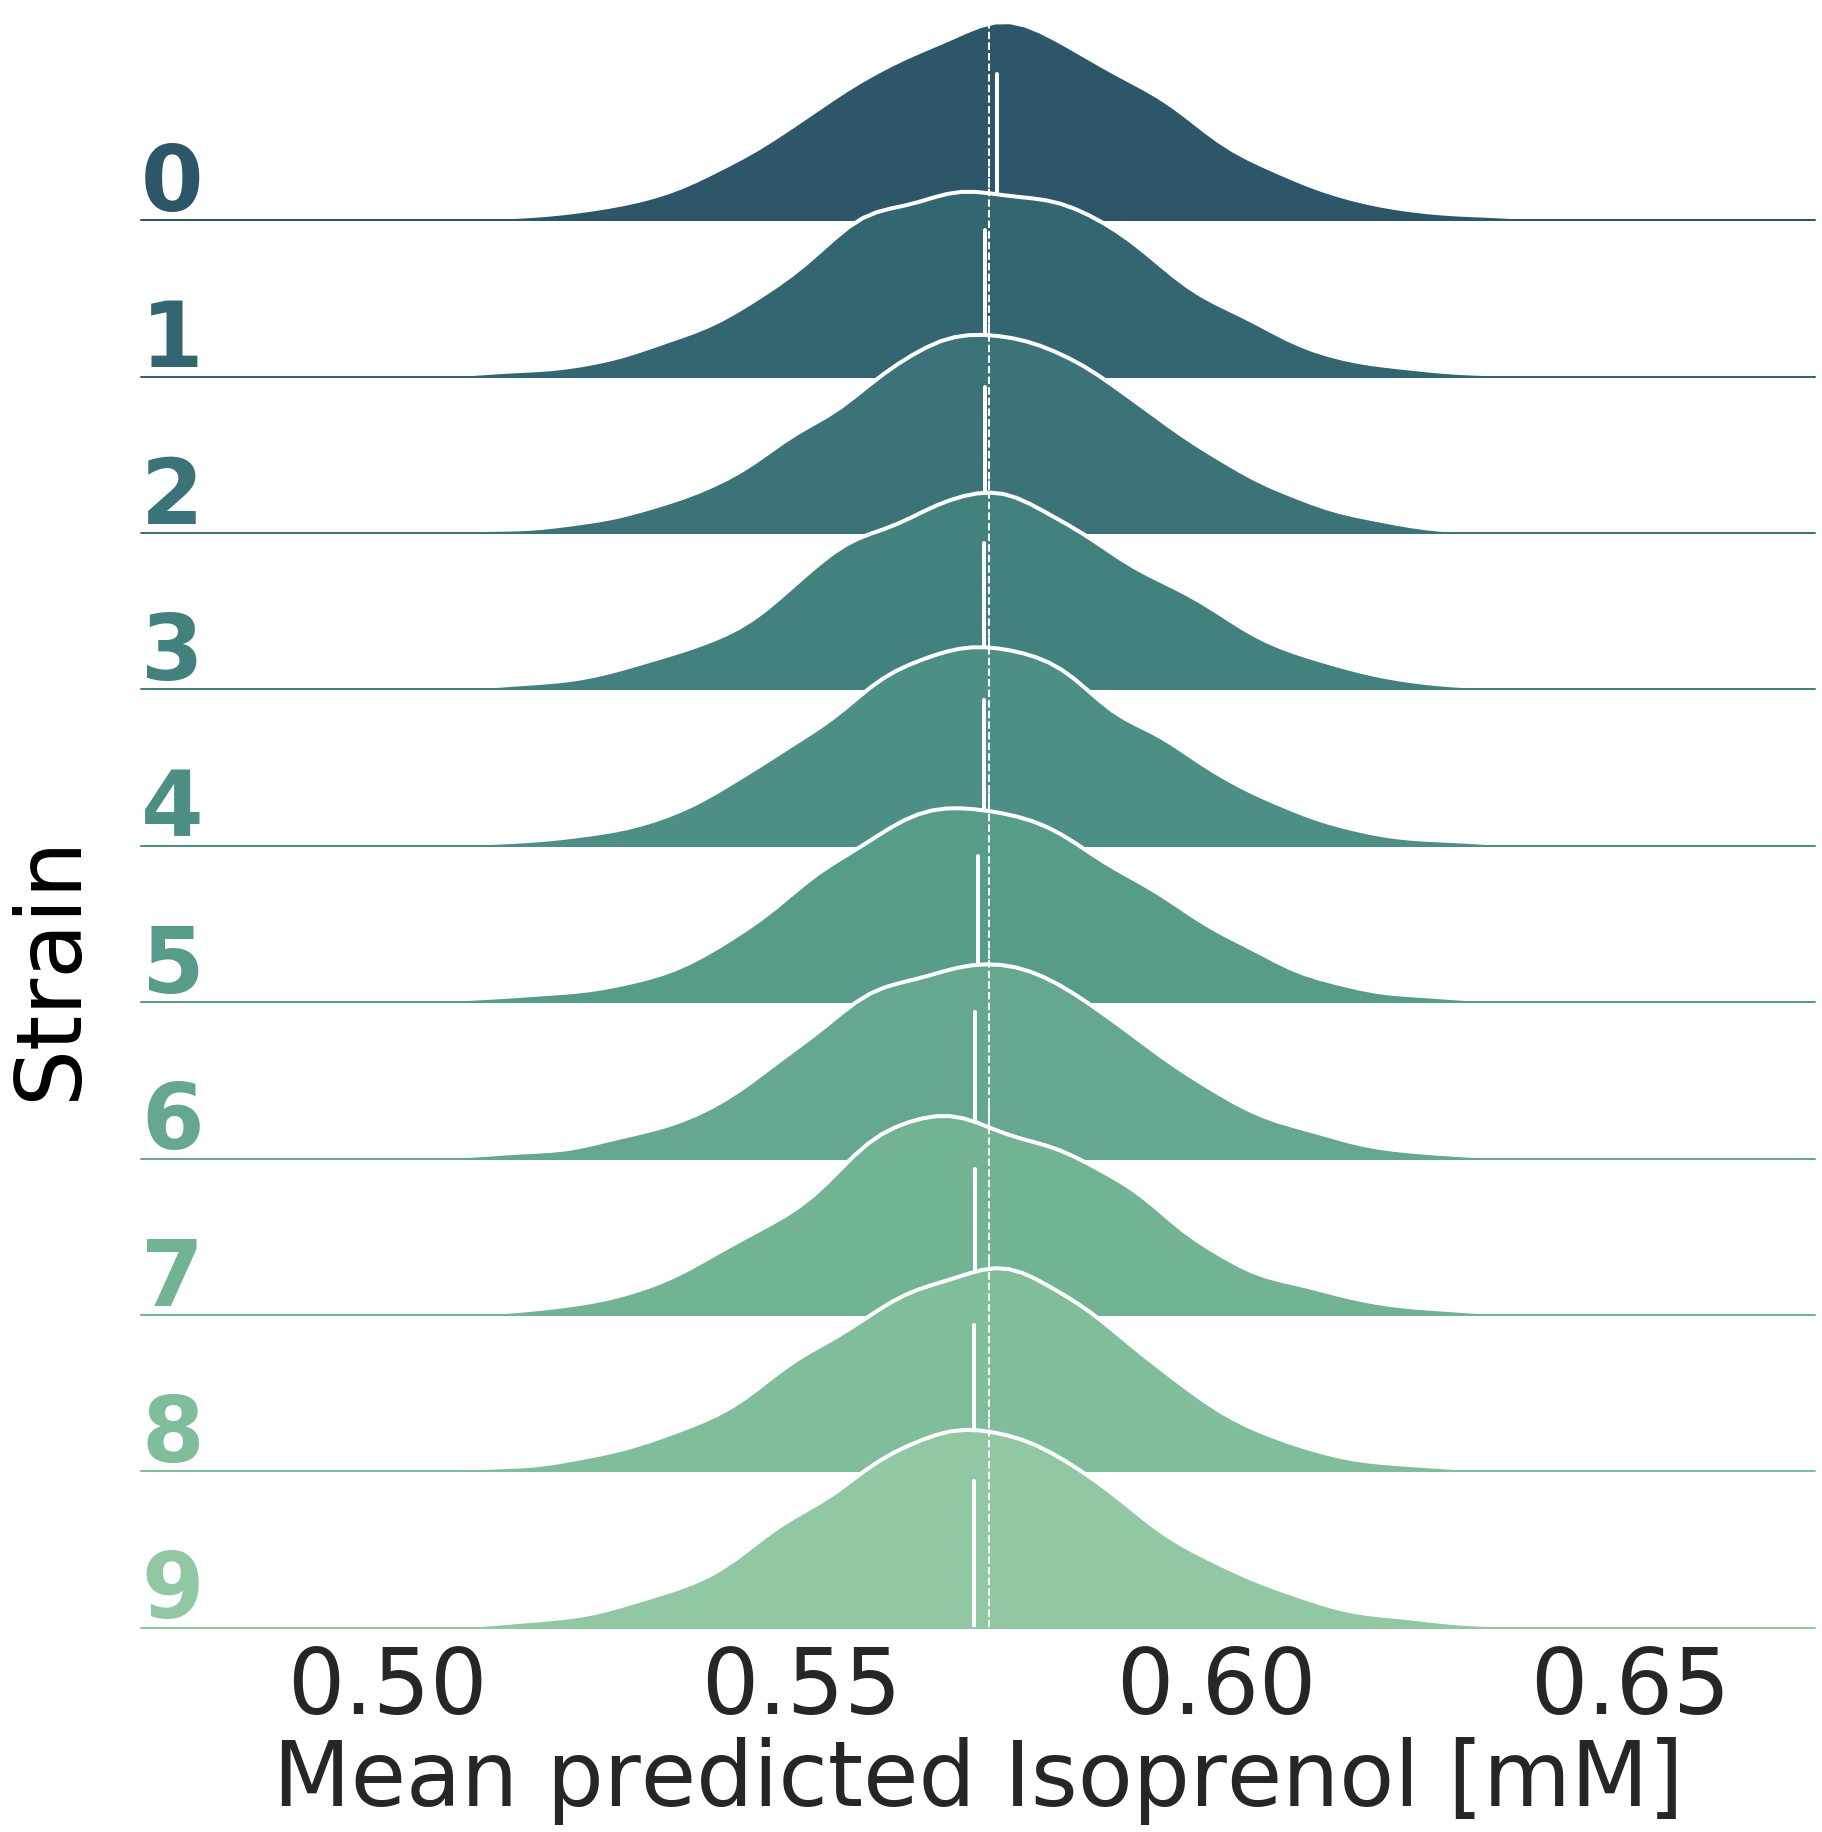

In [27]:
pred_col_name = 'Mean predicted Isoprenol [mM]'
plot.recomm_distribution(art, art.find_current_best(), [pred_col_name])


### Save recommendations into a file

Finally we save the recommendations, along with the predicted production levels. We will compare them with the ground truth provided by OMG in the next notebook. 

First, we change the last column name to indicate it is predicted:

In [28]:
art.recommendations = art.recommendations.rename(columns={art_params['response_var'][0]: pred_col_name})


Then, we add standard deviation predictions for the recommendations:

In [29]:
pp_rec_mean, pp_rec_std = art.post_pred_stats(art.recommendations.values[:,:-1])
art.recommendations['SD Isoprenol [mM]'] = pp_rec_std.copy()


We assign Line Name to each of the recommendations:

In [30]:
n_instances = len(set(df['Line Name']))
art.recommendations.insert(loc=0, column='Line Name', value=['Strain ' + str(n_instances+i) for i in range(1,art_params['num_recommendations']+1)])
art.recommendations.head()


,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Mean predicted Isoprenol [mM],SD Isoprenol [mM]
0,Strain 97,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584,0.019785
1,Strain 98,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193,0.019752
2,Strain 99,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167,0.019752
3,Strain 100,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039,0.019787
4,Strain 101,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967,0.019780


And finally save it in a file:

In [31]:
rec_filename = f'{art.outDir}/ARTrecommendations.csv'
art.recommendations.to_csv(rec_filename, header=True, index=False)